# Carbonate System Calculations (Terminos Lagoon 2024)

- Raw data are aviable in: 

https://metadata.icmyl.unam.mx/bitstream/handle/20.500.12201/11367/MartinezTrejo_etal_2023_TA_DIC_RawData.csv?sequence=1&isAllowed=y



In [1]:
# Import packages
import pandas as pd
import PyCO2SYS as pyco2
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


- Read csv  data file

In [2]:
# Function to read in csv file
def read_csv(file):
    """
    Read in csv file and return pandas dataframe
    """
    df = pd.read_csv(file, sep=",", header=0,  decimal=".", encoding='utf-8')
    return df

In [3]:
# define file path 
terminos_ta_dic_data_path = "../data/terminoslagoon_TA_DIC_2024_RawData.csv"

# Read in data
terminos_ta_dic_raw = read_csv(terminos_ta_dic_data_path)

# Copy raw data to new dataframe
terminos_ta_dic = terminos_ta_dic_raw.copy()

# Delete the raw DataFrame
del terminos_ta_dic_raw


## PyCO2SYS configuration from estuarine waters (Humphreys et al. 2022)

In [4]:
# Copy data to new dataframe
terminos_inorganic_carbon = terminos_ta_dic.copy()

# Create dictionary with data configuration for PyCO2SYS. 
# For more information on the parameters see Humphreys et al (2022)
my_co2sys_params_dic_ta_config = {
    # DIC measured in the lab in μmol/kg-sw
    "par1": terminos_inorganic_carbon["DIC_micromol_kg"],
    # TA measured in the lab, Total scale
    "par2": terminos_inorganic_carbon["TA_micromol_kg"],
    "par1_type": 2,         # tell PyCO2SYS: "par2 is a DIC value"
    "par2_type": 1,         # tell PyCO2SYS: "par1 is a TA value"
    # Fields conditions
    "salinity": terminos_inorganic_carbon["Sal_psu"],  # in-situ salinity in PSU
    # in-situ temperature (output conditions) in °C
    "temperature_out": terminos_inorganic_carbon["Temp_C"],
    "pressure_out": 0.0,
    # Settings
    "opt_pH_scale": 1,     # Total pH (Wolf-Gladrow et al. 2007)
    "opt_k_carbonic": 15,     # 0 < T < 50 °C, 1 < S < 50, Seawater scale, real seawater (Millero F.J. 2010)
    "temperature": 25      # lab temperature (input conditions) in °C
}

### Run PyCO2SYS

In [5]:
# Run PyCO2SYS to calculate the carbonate system parameters
terminos_inorganic_carbon_results= pyco2.sys(**my_co2sys_params_dic_ta_config)

### Read the interes variables from PYCO2sys 

In [6]:
# Select variables of interest from the PyCO2SYS output and concatenate with the original dataframe
CarbonateTL = pd.concat([
       terminos_ta_dic, 
       pd.DataFrame({key: terminos_inorganic_carbon_results[key] for key in [
              "pH", 
              "saturation_aragonite", 
              "pCO2_out", 
              "k_aragonite", 
              "total_calcium", 
              "carbonate" 
       ]})
], axis=1)

- Select Candelaria and Palizada results

In [7]:
CandelariaResult = CarbonateTL.loc[CarbonateTL["Estuary"] == "Candelaria"]
                     
PalizadaResult = CarbonateTL.loc[CarbonateTL["Estuary"] == "Palizada"]

- TA vs DIC Perform  least squares (OLS) regression

In [8]:
#define predictor and response variables
x = CarbonateTL['TA_micromol_kg']
y = CarbonateTL['DIC_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/TA_DIC_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:        DIC_micromol_kg   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1222.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           7.26e-58
Time:                        13:53:50   Log-Likelihood:                -647.75
No. Observations:                 102   AIC:                             1299.
Df Residuals:                     100   BIC:                             1305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -247.0395     88.497     -2.

- TA vas DIC linear Equation

In [9]:
# Calculate the linear regression parameters for TA and DIC
linear_params = model.params

standard_errors = model.bse

Lintercep = f" {linear_params.iloc[0]:.0f}( \pm {standard_errors.iloc[0]:.0f})"

LSlope = f"{linear_params.iloc[1]:.2f}( \pm {standard_errors.iloc[1]:.2f})"

linearEquation= f"$y = {LSlope} \cdot x{Lintercep}$"

Rsquared = f"$r^{2}$ = {model.rsquared:.3f}"

- TA vs DIC , scatter plot  with linear regretion

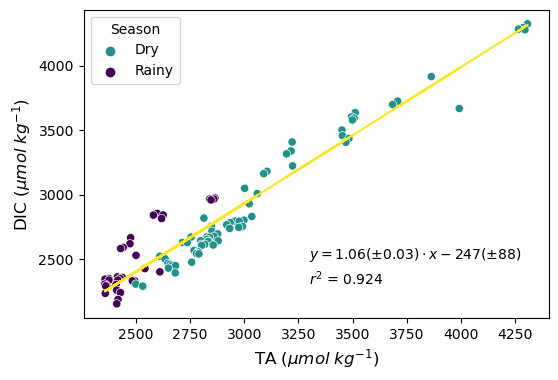

In [10]:
# Plot the relationship between TA and DIC
x = CarbonateTL['TA_micromol_kg']
y = CarbonateTL['DIC_micromol_kg']

# Plot 
g = sns.scatterplot(
    data=CarbonateTL,
    x="TA_micromol_kg", y="DIC_micromol_kg", hue="Season",
    palette=dict(Dry="#21918c", Rainy="#440154")
)

# Add labels and title
plt.xlabel('TA ($\mu mol  \; kg^{-1}$)', fontsize = 12)

plt.ylabel('DIC ($\mu mol  \; kg^{-1}$)', fontsize = 12)

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot linear regression 

plt.plot(x, intercept + slope*x, '#fde725')

# set the figure size
plt.gcf().set_size_inches(6, 4)



plt.text(3300, 2500, linearEquation)

plt.text(3300, 2300, Rsquared)


# save the plot as a PDF file paper format  
plt.savefig('../output_files/05_Fig05_DIC_TA.pdf', dpi=300, bbox_inches='tight')

plt.show()


_____________

-Salinity vs TA ,  Perform  least squares (OLS) regression

In [11]:
import statsmodels.api as sm

#define predictor and response variables
x = CarbonateTL['Sal_psu']
y = CarbonateTL['TA_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/Sal_TA_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:         TA_micromol_kg   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     16.64
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           9.09e-05
Time:                        13:53:54   Log-Likelihood:                -761.71
No. Observations:                 102   AIC:                             1527.
Df Residuals:                     100   BIC:                             1533.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3100.8009     67.745     45.771      0.0

-Salinity  vs TA , scatter plot  with linear regretion

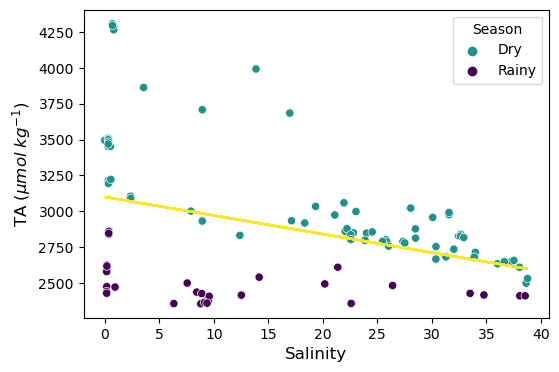

r-squared: 0.142669985748218
Intercept: 3100.800893344719
Slope: -12.916852281816311


In [12]:
import matplotlib.pyplot as plt
from scipy import stats

x = CarbonateTL['Sal_psu']
y = CarbonateTL['TA_micromol_kg']
import seaborn as sns



# Plot sepal width as a function of sepal_length across days
g = sns.scatterplot(
    data=CarbonateTL,
    x="Sal_psu", y="TA_micromol_kg", hue="Season",
    palette=dict(Dry="#21918c", Rainy="#440154")
)


#plt.scatter(x, y, label='original data', color = "#3b528b")

# Add labels and title
plt.xlabel('Salinity', fontsize = 12)

plt.ylabel('TA ($\mu mol  \; kg^{-1}$)', fontsize = 12)

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot linear regression 

plt.plot(x, intercept + slope*x, '#fde725')

# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file paper format 
plt.savefig('../output_files/SAL_TA.tiff', dpi=300, bbox_inches='tight')

plt.show()

# Print linear regression results 

print("r-squared:", r_value**2)
print("Intercept:", intercept)
print("Slope:", slope)

____________________________________________

-Salinity vs DIC ,  Perform  least squares (OLS) regression

In [13]:
import statsmodels.api as sm

#define predictor and response variables
x = CarbonateTL['Sal_psu']
y = CarbonateTL['DIC_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/Sal_DIC_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:        DIC_micromol_kg   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     47.67
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           4.71e-10
Time:                        13:53:57   Log-Likelihood:                -759.53
No. Observations:                 102   AIC:                             1523.
Df Residuals:                     100   BIC:                             1528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3165.3265     66.313     47.733      0.0

- Salinity  vs DIC , scatter plot  with linear regretion

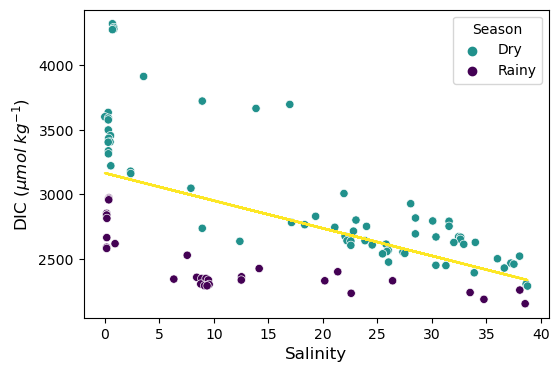

r-squared: 0.3228084313475949
Intercept: 3165.3264755206874
Slope: -21.39938964424291


In [14]:
import matplotlib.pyplot as plt
from scipy import stats

x = CarbonateTL['Sal_psu']
y = CarbonateTL['DIC_micromol_kg']
import seaborn as sns



# Plot sepal width as a function of sepal_length across days
g = sns.scatterplot(
    data=CarbonateTL,
    x="Sal_psu", y="DIC_micromol_kg", hue="Season",
    palette=dict(Dry="#21918c", Rainy="#440154")
)


#plt.scatter(x, y, label='original data', color = "#3b528b")

# Add labels and title
plt.xlabel('Salinity', fontsize = 12)

plt.ylabel('DIC ($\mu mol  \; kg^{-1}$)', fontsize = 12)

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot linear regression 

plt.plot(x, intercept + slope*x, '#fde725')



# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file paper format 
plt.savefig('../output_files/SAL_DIC.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Print linear regression results 

print("r-squared:", r_value**2)
print("Intercept:", intercept)
print("Slope:", slope)

-TA vs DIC ,  Perform  least squares (OLS) regression

-Salinity  vs TA , scatter plot  with linear regretion

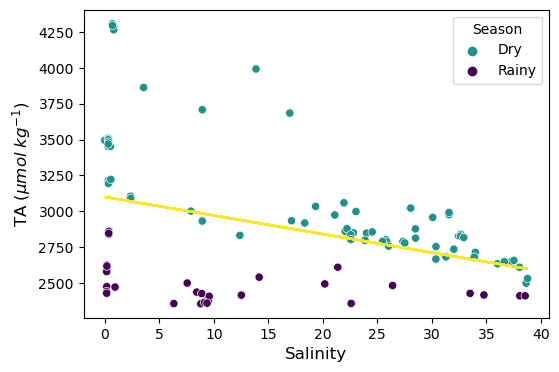

r-squared: 0.142669985748218
Intercept: 3100.800893344719
Slope: -12.916852281816311


In [15]:
# plot the linear regression model 

x = CarbonateTL['Sal_psu']
y = CarbonateTL['TA_micromol_kg']
import seaborn as sns



# Plot sepal width as a function of sepal_length across days
g = sns.scatterplot(
    data=CarbonateTL,
    x="Sal_psu", y="TA_micromol_kg", hue="Season",
    palette=dict(Dry="#21918c", Rainy="#440154")
)


#plt.scatter(x, y, label='original data', color = "#3b528b")

# Add labels and title
plt.xlabel('Salinity', fontsize = 12)

plt.ylabel('TA ($\mu mol  \; kg^{-1}$)', fontsize = 12)

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Plot linear regression 

plt.plot(x, intercept + slope*x, '#fde725')

# set the figure size
plt.gcf().set_size_inches(6, 4)

# save the plot as a PDF file paper format 
plt.savefig('../output_files/SAL_TA.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Print linear regression results 

print("r-squared:", r_value**2)
print("Intercept:", intercept)
print("Slope:", slope)

-Salinity vs DIC ,  Perform  least squares (OLS) regression

In [16]:
#define predictor and response variables
x = CarbonateTL['Sal_psu']
y = CarbonateTL['DIC_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/Sal_DIC_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:        DIC_micromol_kg   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     47.67
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           4.71e-10
Time:                        13:54:04   Log-Likelihood:                -759.53
No. Observations:                 102   AIC:                             1523.
Df Residuals:                     100   BIC:                             1528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3165.3265     66.313     47.733      0.0

-Salinity vs TA ,  Perform  least squares (OLS) regression

In [17]:
import statsmodels.api as sm

#define predictor and response variables
x = CarbonateTL['Sal_psu']
y = CarbonateTL['TA_micromol_kg']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

# export model summary to text file
with open('../output_files/Sal_TA_liner_model_summary.txt', 'w') as file:
    file.write(model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:         TA_micromol_kg   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     16.64
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           9.09e-05
Time:                        13:54:06   Log-Likelihood:                -761.71
No. Observations:                 102   AIC:                             1527.
Df Residuals:                     100   BIC:                             1533.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3100.8009     67.745     45.771      0.0

# References
- Humphreys, M. P., Lewis, E. R., Sharp, J. D., & Pierrot, D. (2022). PyCO2SYS v1.8: Marine carbonate system calculations in Python. Geoscientific Model Development, 15(1), 15–43. https://doi.org/10.5194/gmd-15-15-2022
- Millero, F. J. (2010). Carbonate constants for estuarine waters. Marine and Freshwater Research, 61(2), 139. https://doi.org/10.1071/MF09254
- Wolf-Gladrow, D. A., Zeebe, R. E., Klaas, C., Körtzinger, A., & Dickson, A. G. (2007). Total alkalinity: The explicit conservative expression and its application to biogeochemical processes. Marine Chemistry, 106(1–2), 287–300. https://doi.org/10.1016/j.marchem.2007.01.006

________________